In [2]:
from transformers import pipeline

sentiment_model = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True
)

/Users/calebharding/Documents/BYU/2023-2024/China_Project/qiushi_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
/Users/calebharding/Documents/BYU/2023-2024/China_Project/qiushi_venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_

In [56]:
import pandas as pd

articles = pd.read_csv("../process_articles/minimally_processed_articles.csv")

articles.head(1)

,Unnamed: 0,authors,title,date,year,edition,url,text,quarter,year_quarter
0,0,NaN,本期导读,2024-01-01,2024,1.0,http://www.qstheory.cn/dukan/qs/2024-01/01/c_1...,本期发表了习近平总书记的重要文章《以美丽中国建设全面推进人与自然和谐共生的现代化》。文章强调...,1,2024 Q1


In [36]:
sample = articles.sample(100)

In [37]:
len(sample)

100

In [58]:
def get_empty_results_dict(df):
    sentiment_by_quarter = {}

    for quarter in df["year_quarter"].unique():
        sentiment_by_quarter[quarter] = None
        
    return sentiment_by_quarter

def is_valid_row(text, term):
    # this article has text
    if type(text) != str:
        return False
    
    # the word is contained in the text
    count = text.count(term)
    if count == 0:
        return False
    
    return True

def get_split_sentences(text):
    # replace possible sentence endings with periods, then split on periods
    text = text.replace("？", "。")
    text = text.replace("！", "。")
    text = text.replace("；", "。")

    return text.split("。")

def list_average(list):
    return sum(list) / len(list)
    

def calculate_quarter_sentiment(df, term):
    sentiment_by_quarter = get_empty_results_dict(df)
    print(sentiment_by_quarter)

    for quarter in sentiment_by_quarter.keys():
        print(f"Current quarter: {quarter}")

        temp_df = df.loc[df["year_quarter"] == quarter]

        print(f"Articles in quarter: {len(temp_df)}")

        quarter_pos_scores = []
        quarter_neu_scores = []
        quarter_neg_scores = []

        for index, row in temp_df.iterrows():
            text = row["text"]
            if not is_valid_row(text, term):
                continue

            sentences = get_split_sentences(text)

            # get the sentences with the term
            sentences_w_term = [sentence for sentence in sentences if term in sentence]

            # sentiment of each sentence
            # average for article using the number of sentences
            positive_sent_scores = []
            neutral_sent_scores = []
            negative_sent_scores = []

            for sentence in sentences_w_term:
                try:
                    sentiment_scores = sentiment_model(sentence)
                    positive_sent_scores.append(sentiment_scores[0][0]['score'])
                    neutral_sent_scores.append(sentiment_scores[0][1]['score'])
                    negative_sent_scores.append(sentiment_scores[0][2]['score'])
                except:
                    print(f"Sentiment analysis failed on sentence: {sentence}")

            article_avg_pos = list_average(positive_sent_scores)
            article_avg_neu = list_average(neutral_sent_scores) 
            article_avg_neg = list_average(negative_sent_scores) 

            quarter_pos_scores.append(article_avg_pos)
            quarter_neu_scores.append(article_avg_neu)
            quarter_neg_scores.append(article_avg_neg)


        try:
            quarter_avg_pos = list_average(quarter_pos_scores) 
            quarter_avg_neu = list_average(quarter_neu_scores) 
            quarter_avg_neg = list_average(quarter_neg_scores)
        except:
            quarter_avg_pos = None
            quarter_avg_neu = None
            quarter_avg_neg = None

        results = {"positive":quarter_avg_pos, "neutral":quarter_avg_neu, "negative":quarter_avg_neg}
        sentiment_by_quarter[quarter] = results

    sentiment_by_quarter = {k: v for k, v in sorted(sentiment_by_quarter.items(), key=lambda item: item[0])}

    return sentiment_by_quarter

# function to convert the sentiment results to a csv that can easily be loaded again later
def store_sentiment_results(term=str, quarter_sentiments=dict):
    print(quarter_sentiments)
    df = pd.DataFrame(columns=["year_quarter", "positive", "neutral", "negative"])
    for quarter in quarter_sentiments.keys():
        df.loc[len(df)] = [quarter, quarter_sentiments[quarter]["positive"], quarter_sentiments[quarter]["neutral"], quarter_sentiments[quarter]["negative"]]
    
    filename = term + "_quarter_sentiments.csv"

    df.to_csv(f"./quarter_sentiments/{filename}", index=False)
        
    

In [59]:
econ_sent = calculate_quarter_sentiment(articles, "经济")

{'2024 Q1': None, '2023 Q1': None, '2023 Q2': None, '2023 Q3': None, '2023 Q4': None, '2022 Q1': None, '2022 Q2': None, '2022 Q3': None, '2022 Q4': None, '2021 Q1': None, '2021 Q2': None, '2021 Q3': None, '2021 Q4': None, '2020 Q1': None, '2020 Q2': None, '2020 Q3': None, '2020 Q4': None, '2019 Q1': None, '2019 Q2': None, '2019 Q3': None, '2019 Q4': None}
Current quarter: 2024 Q1
Articles in quarter: 33
Current quarter: 2023 Q1
Articles in quarter: 124
Current quarter: 2023 Q2
Articles in quarter: 115
Current quarter: 2023 Q3
Articles in quarter: 118
Current quarter: 2023 Q4
Articles in quarter: 113
Current quarter: 2022 Q1
Articles in quarter: 110
Current quarter: 2022 Q2
Articles in quarter: 124
Current quarter: 2022 Q3
Articles in quarter: 117
Current quarter: 2022 Q4
Articles in quarter: 126
Sentiment analysis failed on sentence: 五年来，以习近平同志为核心的党中央高举中国特色社会主义伟大旗帜，全面贯彻党的十九大和十九届历次全会精神，坚持马克思列宁主义、毛泽东思想、邓小平理论、“三个代表”重要思想、科学发展观，全面贯彻习近平新时代中国特色社会主义思想，团结带领全党全军全国各族人民，统揽伟大斗争、伟大工程、伟大事业、伟大梦想，统筹推进“

In [61]:
econ_sent

{'2019 Q1': {'positive': 0.6953084295092483,
  'neutral': 0.11523964279319113,
  'negative': 0.18945192478192882},
 '2019 Q2': {'positive': 0.6361212212595074,
  'neutral': 0.1285363655084614,
  'negative': 0.23534241388155697},
 '2019 Q3': {'positive': 0.6415961443609015,
  'neutral': 0.126893907563781,
  'negative': 0.23150994934625385},
 '2019 Q4': {'positive': 0.7095640733217181,
  'neutral': 0.10352915279768929,
  'negative': 0.1869067758127391},
 '2020 Q1': {'positive': 0.713309171147747,
  'neutral': 0.10904668659884019,
  'negative': 0.17764414271960743},
 '2020 Q2': {'positive': 0.7075650028111354,
  'neutral': 0.11256608148440253,
  'negative': 0.1798689173366008},
 '2020 Q3': {'positive': 0.7388155810368405,
  'neutral': 0.09849448366445979,
  'negative': 0.16268993028951262},
 '2020 Q4': {'positive': 0.7660810595798265,
  'neutral': 0.10145554645171072,
  'negative': 0.1324633966759065},
 '2021 Q1': {'positive': 0.7137896835638295,
  'neutral': 0.10979029346497411,
  'negat

In [62]:
store_sentiment_results("经济", econ_sent)

{'2019 Q1': {'positive': 0.6953084295092483, 'neutral': 0.11523964279319113, 'negative': 0.18945192478192882}, '2019 Q2': {'positive': 0.6361212212595074, 'neutral': 0.1285363655084614, 'negative': 0.23534241388155697}, '2019 Q3': {'positive': 0.6415961443609015, 'neutral': 0.126893907563781, 'negative': 0.23150994934625385}, '2019 Q4': {'positive': 0.7095640733217181, 'neutral': 0.10352915279768929, 'negative': 0.1869067758127391}, '2020 Q1': {'positive': 0.713309171147747, 'neutral': 0.10904668659884019, 'negative': 0.17764414271960743}, '2020 Q2': {'positive': 0.7075650028111354, 'neutral': 0.11256608148440253, 'negative': 0.1798689173366008}, '2020 Q3': {'positive': 0.7388155810368405, 'neutral': 0.09849448366445979, 'negative': 0.16268993028951262}, '2020 Q4': {'positive': 0.7660810595798265, 'neutral': 0.10145554645171072, 'negative': 0.1324633966759065}, '2021 Q1': {'positive': 0.7137896835638295, 'neutral': 0.10979029346497411, 'negative': 0.176420025694596}, '2021 Q2': {'posit

In [42]:
import matplotlib.pyplot as plt

def graph_sentiment_trends(file, term):
    df = pd.read_csv(file)
    df = df.dropna()

    fig, ax = plt.subplots()

    xvals = df['year_quarter']

    for sentiment in ['positive', 'neutral', 'negative']:
        yvals = df[sentiment]
        ax.plot(xvals, yvals, label=sentiment)

    ax.set_xlabel("Quarter")
    ax.set_ylabel("Sentiment Level")
    ax.set_title(f"Sentiment Around {term} in Qiushi Over Time")
    ax.legend()
    ax.tick_params(axis='x', rotation=50)
    ax.grid()
    plt.show()


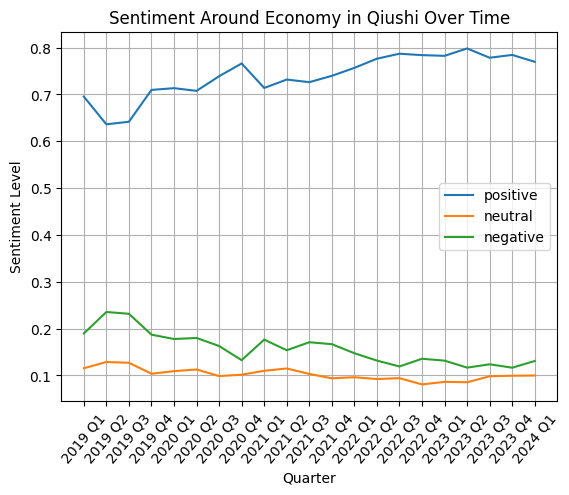

In [63]:
graph_sentiment_trends("./quarter_sentiments/经济_quarter_sentiments.csv", "Economy")

In [51]:
us_sent = calculate_quarter_sentiment(articles, "美国")

{'2024 Q1': None, '2023 Q1': None, '2023 Q2': None, '2023 Q3': None, '2023 Q4': None, '2022 Q1': None, '2022 Q2': None, '2022 Q3': None, '2022 Q4': None, '2021 Q1': None, '2021 Q2': None, '2021 Q3': None, '2021 Q4': None, '2020 Q1': None, '2020 Q2': None, '2020 Q3': None, '2020 Q4': None, '2019 Q1': None, '2019 Q2': None, '2019 Q3': None, '2019 Q4': None}
Current quarter: 2024 Q1
Articles in quarter: 33
Current quarter: 2023 Q1
Articles in quarter: 124
Current quarter: 2023 Q2
Articles in quarter: 115
Current quarter: 2023 Q3
Articles in quarter: 118
Current quarter: 2023 Q4
Articles in quarter: 113
Current quarter: 2022 Q1
Articles in quarter: 110
Current quarter: 2022 Q2
Articles in quarter: 124
Current quarter: 2022 Q3
Articles in quarter: 117
Current quarter: 2022 Q4
Articles in quarter: 126
Current quarter: 2021 Q1
Articles in quarter: 112
Current quarter: 2021 Q2
Articles in quarter: 95
Current quarter: 2021 Q3
Articles in quarter: 93
Current quarter: 2021 Q4
Articles in quarter:

In [52]:
store_sentiment_results("美国", us_sent)

{'2019 Q1': {'positive': 0.5780602077917233, 'neutral': 0.14407352317785804, 'negative': 0.27786626543414283}, '2019 Q2': {'positive': 0.4873917760732381, 'neutral': 0.14991333439818183, 'negative': 0.36269488165398484}, '2019 Q3': {'positive': 0.469179542453, 'neutral': 0.17129235522765102, 'negative': 0.35952810663729906}, '2019 Q4': {'positive': 0.5453313445051512, 'neutral': 0.18540669549749328, 'negative': 0.26926195404576087}, '2020 Q1': {'positive': 0.6115378232842142, 'neutral': 0.15885994848654125, 'negative': 0.22960224386417505}, '2020 Q2': {'positive': 0.6053469756189508, 'neutral': 0.17322526408715927, 'negative': 0.2214277474639786}, '2020 Q3': {'positive': 0.4314907704376512, 'neutral': 0.1343586085519443, 'negative': 0.4341506210362746}, '2020 Q4': {'positive': 0.39501761991126755, 'neutral': 0.14105722495806997, 'negative': 0.4639251438060769}, '2021 Q1': {'positive': 0.6507414816982217, 'neutral': 0.13858125120125436, 'negative': 0.21067727030496355}, '2021 Q2': {'pos

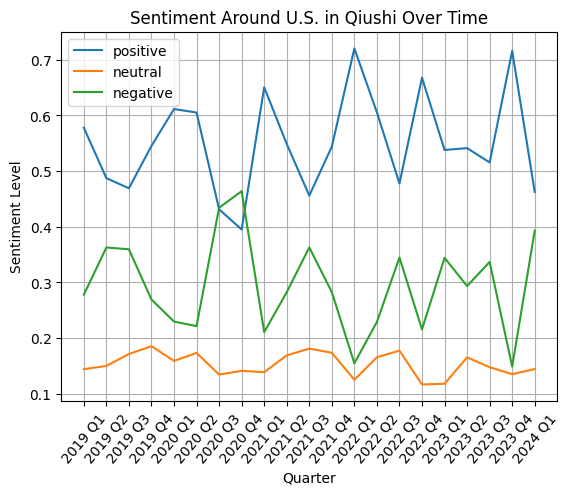

In [53]:
graph_sentiment_trends("./quarter_sentiments/美国_quarter_sentiments.csv", "U.S.")